## Housing, Health & Happiness - Creative Extension - Benchmark Analysis

### I. Importing Libraries and Data

In [14]:
### Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas.util.testing as tm
import seaborn as sns
import ipywidgets as ipw

### Import data

DATA_FOLDER = 'Data/'

# NaN values are replaced with 0, as described in the paper 
# SHOULD WE DROP NaN VALUES OR PUT THEM TO 0 ? IT CHANGES THE VALUE FOR THE MEAN !!

household_data = pd.read_stata(DATA_FOLDER + 'PisoFirme_AEJPol-20070024_household.dta')
individual_data = pd.read_stata(DATA_FOLDER + 'PisoFirme_AEJPol-20070024_individual.dta')

In [15]:
household_data = household_data[household_data["idcluster"].notnull()]
print('treatment:', len(household_data[household_data['dpisofirme'] == 1]))
print('control:', len(household_data[household_data['dpisofirme'] == 0]))

treatment: 1362
control: 1393


### II. Is the original matching truly balanced ? 

> In the paper 'Housing, Health, and Happiness', the treatment and control group are matched according to the variables C_blockdirtfloor, C_HHdirtfloor, C_child05 and C_households. The paper claims that these 4 variables are balances, according to Table 2 where the means for treatment and control are computed, along with standard errors and the mean difference. Let us verify with statistical tests that this is indeed the case.  
> We can start by visualising the distribution of these four variables for treatment and control. 

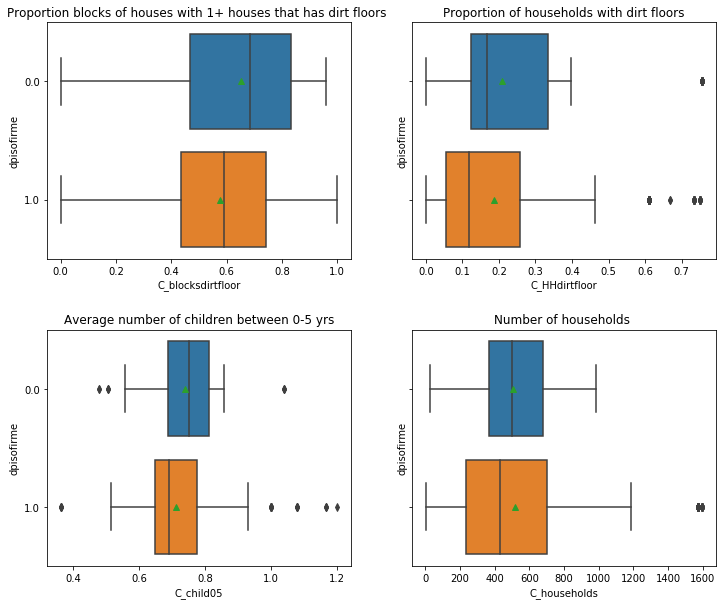

In [4]:
# Creating boxplot graphs for the 4 matching variables 

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
fig.subplots_adjust(hspace=0.3)

sns.boxplot(ax=axes[0,0], x=household_data['C_blocksdirtfloor'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[0,0].set_title('Proportion blocks of houses with 1+ houses that has dirt floors ')

sns.boxplot(ax=axes[0,1], x=household_data['C_HHdirtfloor'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[0,1].set_title('Proportion of households with dirt floors');

sns.boxplot(ax=axes[1,0], x=household_data['C_child05'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[1,0].set_title('Average number of children between 0-5 yrs');

sns.boxplot(ax=axes[1,1], x=household_data['C_households'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[1,1].set_title('Number of households ');

> Next, to verify whether the populations of treatment and control are comparable, we can use the t-test, which verifies the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default, but we define as False if the variances are not equal (known as Welch's t-test).

In [5]:
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import ttest_ind

df_mean = pd.DataFrame(columns = household_data.columns).reset_index()
df_mean['index'] = ['T-test', 'Identical Mean']

for col in household_data:
    
    a = household_data[col][household_data['dpisofirme'] == 1]
    b = household_data[col][household_data['dpisofirme'] == 0]
    ttest = ttest_ind(a, b, equal_var = False, nan_policy = 'omit')
    if (ttest.pvalue < 0.05):
        identical_mean = False
    else:
        identical_mean = True
        
    df_mean[col] = pd.Series([ttest.pvalue, identical_mean])
    
df_mean = df_mean.drop(df_mean.columns[[1, 2, 3, 4, 5, 6]], axis = 1)
df_mean

,index,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,C_people,C_rooms,C_HHpersons,C_waterland,C_waterhouse,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
0,T-test,9.70199e-19,0.00129062,4.37931e-14,0.336326,0.868967,0.00871867,1.75265e-24,1.14142e-16,7.49144e-13,...,7.55146e-11,1.38662e-11,7.68224e-116,0.116793,0.856338,0.0479387,0.309241,0.00924342,0.239531,0.354305
1,Identical Mean,False,False,False,True,True,False,False,False,False,...,False,False,False,True,True,False,True,False,True,True


> It appears that the mean values for 3 of the 4 variables used for the matching are not balanced, as the statistical test yields a p-value below the threshold of 0.05, indicating that we must reject the null hypothesis of equal averages. This puts into question the use of these variables for matching in the context of the study.

### Tool to check the distribution of other variables

> In order to check the distribution of all variables available in the study, the following tool is proposed: a widget which allows the choice of the input variables for the boxplots. This allows to visualise the distributions for any variable easily and efficiently. 

In [7]:
selection_data = household_data.columns[6:]
selection_1 = ipw.Dropdown(
    options=selection_data,
    description='Variable 1')
selection_2 = ipw.Dropdown(
    options=selection_data,
    description='Variable 2')
selection_3 = ipw.Dropdown(
    options=selection_data,
    description='Variable 3')
box = ipw.HBox([selection_1, selection_2, selection_3])
display(box)

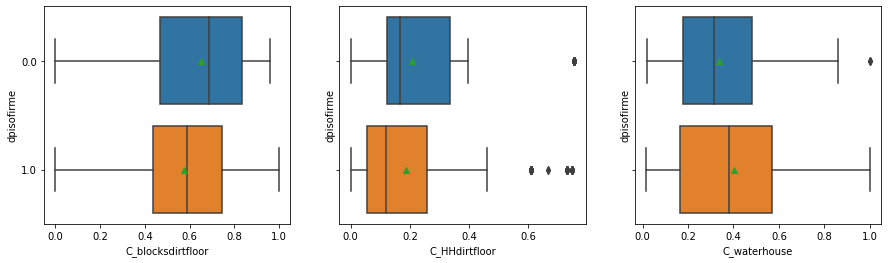

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
fig.subplots_adjust(hspace=0.5)

sns.boxplot(ax=axes[0], x=household_data[selection_1.value], y=household_data['dpisofirme'], showmeans=True, orient='h');

sns.boxplot(ax=axes[1], x=household_data[selection_2.value], y=household_data['dpisofirme'], showmeans=True, orient='h');

sns.boxplot(ax=axes[2], x=household_data[selection_3.value], y=household_data['dpisofirme'], showmeans=True, orient='h');

### Plotly visualisation for datastory 

> Plotly is used to visualise the boxplot distributions of the four matching variables, and convert the graph to html in order to include the result in the datastory. The use of plotly enables the use of interactive features on the graph. 

In [30]:
import plotly.graph_objects as go
import numpy 
  
x = household_data['dpisofirme']
y1 = household_data['C_blocksdirtfloor']
y2 = household_data['C_HHdirtfloor']
y3 = household_data['C_child05']
y4 = household_data['C_households']

plot = px.Figure(data=[go.Box( 
    name='C_blocksdirtfloor', 
    x=x, 
    y=y1 
), 
    go.Box( 
    name='C_HHdirtfloor', 
    x=x, 
    y=y2, visible = "legendonly", marker_color='#3D9970'
), 
    go.Box( 
    name='C_child05', 
    x=x, 
    y=y3, visible = "legendonly", marker_color='#FF4136'
),
                       go.Box( 
    name='C_households', 
    x=x, 
    y=y4, visible = "legendonly", marker_color='#FF851B'
)                       
])


plot.update_layout(
    xaxis=dict(title='dpisofirme', zeroline=False),
    title='<b>'+'Proportion blocks of houses with 1+ houses that has dirt floors'+'</b>',
    updatemenus=[ 
        dict( 
            active=0, 
            buttons=list([
                dict(label="C_blocksdirtfloor", 
                     method="update", 
                     args=[{"visible": [True, False, False, False]}, 
                           {"title": '<b>'+"Proportion blocks of houses with 1+ houses that has dirt floors"+'</b>', 
                            }]), 
                dict(label="C_HHdirtfloor", 
                     method="update", 
                     args=[{"visible": [False, True, False, False]}, 
                           {"title": '<b>'+"Proportion of households with dirt floors"+'</b>', 
                            }]),
                dict(label="C_child05", 
                     method="update", 
                     args=[{"visible": [False, False, True, False]}, 
                           {"title": '<b>'+"Average number of children between 0-5 yrs"+'</b>', 
                            }]), 
                dict(label="C_households", 
                     method="update", 
                     args=[{"visible": [False, False, False, True]}, 
                           {"title": '<b>'+"Number of households"+'</b>', 
                            }]), 
            ]), 
        ) 
    ]) 
  
plot.show() 
plot.write_html("boxplot_figure.html")

### III. Benchmarking
> Omitted variable bias can affect treatment effect estimates obtained from observational data due to the lack of random assignment to treatment groups. Sensitivity analyses adjust these estimates to quantify the impact of potential omitted variables.
> As a first step of a sensitivity analysis, one can use benchmarking: the use of available data to establish reference points for speculation about omitted confounders. 
> In this case, we look at the effect of regressors used in the linear regression models on R^2. We can isolate each variable of the models and see the change incurred in R^2 when the regressors are not included in the model. This enables a classification 
of the most predictive regressors in terms of R^2. Indeed, the difference in R^2 corresponds to the bias that would have been incurred by omitting said variable in the model. 


In [16]:
### Creating a Dataframe to collect the data

R2_df = pd.DataFrame(columns = ['Total Model 3 R2', 'S_HHpeople', 'S_headage','S_spouseage','S_headeduc',\
                                'S_spouseeduc', 'S_dem1','S_dem2','S_dem3','S_dem4','S_dem5','S_dem6','S_dem7','S_dem8',\
                                'C(S_waterland)','C(S_waterhouse)','C(S_electricity)','C(S_hasanimals)','C(S_animalsinside)',\
                                'C(S_garbage)', 'S_washhands', 'S_cashtransfers', 'C(S_milkprogram)', 'C(S_foodprogram)',\
                                'C(S_seguropopular)']).reset_index()
R2_df['index'] = ['Share of rooms with cement floors', 'Cement floor in kitchen',\
                  'Cement floor in dining room', 'Cement floor in bathroom', 'Cement floor in bedroom']

In [17]:
### Function which allows to delete the z^th regressor of the model x 
# Creates the necessary string to input in the statsmodel linear regression

def create_mod_str(x,z):
    output_str = ''
    for i in range(0,len(x)):
        if((i != z) and (i != len(x)-1)):
            output_str = output_str + x[i] + ' + '
        if(i == len(x)-1):
            output_str = output_str + x[i]
    return output_str

In [18]:
### Computing the omitted variable bias 

# Looking at Model 3 for Table 4 of the paper

mod_variables = ['S_shcementfloor', 'S_cementfloorkit', 'S_cementfloordin', 'S_cementfloorbat', 'S_cementfloorbed']
mod_regressors = ['S_HHpeople', 'S_headage','S_spouseage','S_headeduc',\
                  'S_spouseeduc', 'S_dem1','S_dem2','S_dem3','S_dem4','S_dem5','S_dem6','S_dem7','S_dem8',\
                  'C(S_waterland)','C(S_waterhouse)','C(S_electricity)','C(S_hasanimals)','C(S_animalsinside)',\
                  'C(S_garbage)', 'S_washhands', 'S_cashtransfers', 'C(S_milkprogram)', 'C(S_foodprogram)',\
                  'C(S_seguropopular)']
model3 = 'C(dpisofirme) + S_HHpeople + S_headage + S_spouseage + \
                     S_headeduc + S_spouseeduc + S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6 + S_dem7 \
                     + S_dem8 + C(S_waterland) + C(S_waterhouse) + C(S_electricity) + C(S_hasanimals) + \
                     C(S_animalsinside) + C(S_garbage) + S_washhands + S_cashtransfers + C(S_milkprogram) +\
                     C(S_foodprogram) + C(S_seguropopular)'

for i in range(0,5):
    
    # Declaring the complete Model
    mod = smf.ols(formula = mod_variables[i] + ' ~ ' + model3, data = household_data.fillna(0))

    # Fitting Model
    np.random.seed(2)
    res = mod.fit(cov_type = 'cluster', cov_kwds={'groups': household_data.fillna(0)['idcluster']})
    R2 = res.rsquared
    R2_df['Total Model 3 R2'].iloc[i] = R2
    
    for j in range(len(mod_regressors)):
    
        # Declaring the Model
        mod = smf.ols(formula = mod_variables[i] + ' ~ ' + 'C(dpisofirme) + '+ create_mod_str(mod_regressors,j),\
                      data = household_data.fillna(0))

        # Fitting Model
        np.random.seed(2)
        res = mod.fit(cov_type = 'cluster', cov_kwds={'groups': household_data.fillna(0)['idcluster']})
        R2 = res.rsquared
        R2_df[mod_regressors[j]].iloc[i] = 100*((1-R2)-(1-R2_df['Total Model 3 R2'].iloc[i]))/(1-R2_df['Total Model 3 R2'].iloc[i])

R2_df

,index,Total Model 3 R2,S_HHpeople,S_headage,S_spouseage,S_headeduc,S_spouseeduc,S_dem1,S_dem2,S_dem3,...,C(S_waterhouse),C(S_electricity),C(S_hasanimals),C(S_animalsinside),C(S_garbage),S_washhands,S_cashtransfers,C(S_milkprogram),C(S_foodprogram),C(S_seguropopular)
0,Share of rooms with cement floors,0.192373,0.115478,0.425326,0.129028,0.910849,0.183761,0.0488035,0.0108296,0.0193907,...,3.04094,0.166115,0.000865248,0.275758,0.0130743,0.274298,0.138569,0.062958,0.0198699,0
1,Cement floor in kitchen,0.158954,0.0836849,0.460772,0.145985,0.85522,0.022074,0.0387888,0.00895754,0.0161408,...,1.60576,0.0964071,0.0620095,0.252959,0.0349196,0.456242,0.304069,0.00138107,0.0106346,0
2,Cement floor in dining room,0.124774,0.0651422,0.558492,0.218954,0.878212,0.0129642,0.0319834,0.0151296,0.0244372,...,2.08363,0.0673653,0.0858416,0.0439766,0.0412808,0.062521,0.202429,0.00790337,0.0586517,0
3,Cement floor in bathroom,0.104005,0.00453124,0.158553,0.00485927,0.286551,0.492958,0.0400443,0.01263,0.00994473,...,2.44861,0.305893,0.0792816,0.0763971,0.895113,0.314818,0.0150716,0.132713,0.101011,0
4,Cement floor in bedroom,0.136415,1.08878,0.018522,0.20708,0.585848,0.0479563,0.00741082,0.00236146,0.00859723,...,0.846553,0.116584,0.0052729,0.219116,9.31746e-05,0.0774747,9.52891e-05,0.0460254,0.00701391,0


In [31]:
from plotly import graph_objs as go

variables = R2_df['index']
counter = 0;
R2_fig = R2_df.drop(['index','Total Model 3 R2'], axis=1)

fig = go.Figure()

for vb in variables:
    
    if(counter != 0):
        trace = go.Bar(x=R2_fig.columns, y=R2_fig.iloc[counter], name=vb, visible = "legendonly")
    if(counter == 0):
        trace = go.Bar(x=R2_fig.columns, y=R2_fig.iloc[counter], name=vb)
        
    fig.add_trace(trace)
    
    counter=counter+1

fig.update_layout(
    {'title_text': '<b>'+'Reduction in unexplained variance'+'</b>',
        'xaxis': dict(title='Regressors', tickangle=45),
        'yaxis_title_text': r'$\rho^2$',
        "autosize": True})
fig.show()
fig.write_html("Bias_Figure.html")

### Random

In [13]:
selection = ipw.SelectMultiple(
    options=household_data.columns,
    description='Variables',
    layout=ipw.Layout(display="flex", flex_flow='column'))
selection

SelectMultiple(description='Variables', layout=Layout(display='flex', flex_flow='column'), options=('dpisofirm…

In [14]:
Tot = len(selection.value)
Cols = 4

# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

# Create main figure

fig = plt.figure(figsize=(Tot*3, Tot*2))
fig.subplots_adjust(hspace=0.5,wspace = 0.3)

for k in range(Tot):
    ax = fig.add_subplot(Rows,Cols,Position[k])    
    sns.boxplot(x=household_data[selection.value[k]], y=household_data['dpisofirme'], showmeans=True, orient='h');

plt.show()

<Figure size 0x0 with 0 Axes>